<a href="https://colab.research.google.com/github/raniau1353/Adversarial_Learning_Classifier/blob/main/Debiased_Classifier_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read input

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F # for activation function
from torch.optim import Adam 

import pandas as pd
import numpy as np 
from sklearn.preprocessing import OneHotEncoder

# read in datasets and transform to tensors
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

# define one hot encoder
encoder = OneHotEncoder(sparse=False)

# embedding 
income_labels = {' <=50K': 0, ' >50K': 1} # create the labels
workclass_labels = {' Private': 0, ' Self-emp-not-inc': 1, ' Local-gov': 2 , ' ?': 3, ' State-gov': 4, ' Self-emp-inc': 5, ' Federal-gov': 6, 
                    ' Without-pay': 7, ' Never-worked': 8}
education_labels = {' HS-grad': 0, ' Some-college': 2, ' Bachelors': 3, ' Masters': 4, ' Assoc-voc': 5, ' 11th': 6, ' Assoc-acdm': 7, ' 10th': 8, 
                      ' 7th-8th': 9, ' Prof-school': 10, ' 9th': 11, ' 12th': 12, ' Doctorate': 13, ' 5th-6th': 14, ' 1st-4th': 15, ' Preschool': 16}
marital_status_labels = {' Married-civ-spouse': 0, ' Never-married': 1, ' Divorced': 2, ' Separated': 3, ' Widowed': 4, ' Married-spouse-absent': 5, 
                         ' Married-AF-spouse': 6}
occupation_labels = {' Prof-specialty': 0, ' Craft-repair': 1, ' Exec-managerial': 2, ' Adm-clerical': 3, ' Sales': 4, ' Other-service': 5, 
                     ' Machine-op-inspct': 6, ' ?': 7, ' Transport-moving': 8, ' Handlers-cleaners': 9, ' Farming-fishing': 10, ' Tech-support': 11, 
                     ' Protective-serv': 12, ' Priv-house-serv': 13, ' Armed-Forces': 14}
relationship_labels = {' Husband': 0, ' Not-in-family': 1, ' Own-child': 2, ' Unmarried': 3, ' Wife': 4, ' Other-relative': 5}
race_labels = {' White': 0, ' Black': 1, ' Asian-Pac-Islander': 2, ' Amer-Indian-Eskimo': 3, ' Other': 4}
sex_labels = {' Male': 0, ' Female': 1}
native_country_labels = {' United-States': 0, ' Mexico': 1, ' ?': 2, ' Philippines': 3, ' Germany': 4, ' Canada': 5, ' Puerto-Rico': 6, ' El-Salvador': 7, 
                         ' India': 8, ' Cuba': 9, ' England': 10, ' Jamaica': 11, ' South': 12, ' China': 13, ' Italy': 14, ' Dominican-Republic': 15, 
                         ' Vietnam': 16, ' Guatemala': 17, ' Japan': 18, ' Poland': 19, ' Columbia': 20, ' Taiwan': 21, ' Haiti': 22, ' Iran': 23, 
                         ' Portugal': 24, ' Nicaragua': 25, ' Peru': 26, ' France': 27, ' Greece': 28, ' Ecuador': 29, ' Ireland': 30, ' Hong': 31, 
                         ' Cambodia': 32, ' Trinadad&Tobago': 33, ' Laos': 34, ' Thailand': 34, ' Yugoslavia': 35, ' Outlying-US(Guam-USVI-etc)': 36, 
                         ' Honduras': 37, ' Hungary': 38, ' Scotland': 39, ' Holand-Netherlands': 40}

# add output column for classifier
df['Income_num'] = df['income']
df.Income_num = [income_labels[item] for item in df.Income_num]

# add output column for adversary
df['Sex_num'] = df['sex']
df.Sex_num = [sex_labels[item] for item in df.Sex_num]

# add input columns
df['Workclass_num'] = df['workclass']
df['Education_num'] = df['education']
df['Marital_Status_num'] = df['marital-status']
df['Occupation_num'] = df['occupation']
df['Relationship_num'] = df['relationship']
df['Race_num'] = df['race']
df['Native_Country_num'] = df['native-country']
df['Capital_Gain_num'] = df['capital-gain']
df['Capital_Loss'] = df['capital-loss']
df['Hours_per_week'] = df['hours-per-week']

df.Workclass_num = [workclass_labels[item] for item in df.Workclass_num]
df.Education_num = [education_labels[item] for item in df.Education_num]
df.Marital_Status_num = [marital_status_labels[item] for item in df.Marital_Status_num]
df.Occupation_num = [occupation_labels[item] for item in df.Occupation_num]
df.Relationship_num = [relationship_labels[item] for item in df.Relationship_num]
df.Race_num = [race_labels[item] for item in df.Race_num]
df.Native_Country_num = [native_country_labels[item] for item in df.Native_Country_num]

# define input and output columns
x1 = df.iloc[:, 17:24] 
x2 = df.iloc[:, 24:]
onehot_input = encoder.fit_transform(x1)
x1_tensor = torch.tensor(onehot_input)
x2_tensor = torch.tensor(x2.to_numpy())

x_var = torch.cat((x1_tensor, x2_tensor), -1)
z_var = df.loc[:, 'Sex_num']
y_var = df.loc[:, 'Income_num']

print('\nx_data format: ', x_var.shape, x_var.dtype)
print(x_var)
y_var = torch.tensor(y_var.to_numpy()) # Output format: torch.Size([150]) torch.int64 
print('\ny_data format: ', y_var.shape, y_var.dtype)
z_var = torch.tensor(z_var.to_numpy()) # Adversary Output format:  torch.Size([32561]) torch.int64
print('\nz_data format: ', z_var.shape, z_var.dtype)

data = TensorDataset(x_var, y_var, z_var)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



x_data format:  torch.Size([32561, 102]) torch.float64
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.1740e+03, 0.0000e+00,
         4.0000e+01],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3000e+01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.0000e+01],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.0000e+01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.0000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5024e+04, 0.0000e+00,
         4.0000e+01]], dtype=torch.float64)

y_data format:  torch.Size([32561]) torch.int64

z_data format:  torch.Size([32561]) torch.int64


60% data used for training, 20% validation, 30% testing
start with 64, 128 for batch size

32561 * 0.6 = ~19536
64 batch size -> ~305 batches




In [ ]:
import pdb
# split to train, validate, and test sets using random_split
# 50% of data used for training, 20% for validation, 30% testing
number_rows = len(x_var)
test_split = int(number_rows*0.3)
validate_split = int(number_rows*0.2)
train_split = number_rows - test_split - validate_split
train_set, validate_set, test_set = random_split( 
    data, [train_split, validate_split, test_split]) 

# create dataloader to read data
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
print(train_loader)
validate_loader = DataLoader(validate_set, batch_size = 1)
test_loader = DataLoader(test_set, batch_size = 1)

print('# training samples:', number_rows)
print('# batches:', len(train_loader))

# training samples: 32561
# batches: 509


# Create model

layers: (8, 24) -> (24, 24) -> (24, 2)

learning rate = 0.01

In [ ]:
x_var_size = list(x_var.shape)[1] 
print(x_var_size)
learning_rate = 0.01 
y_var_size = len(income_labels)
class Network(nn.Module):

  def __init__(self, x_var_size, y_var_size):
    super(Network, self).__init__()

    self.layer1 = nn.Linear(x_var_size, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, y_var_size)

  def forward(self, x):
    x1 = F.relu(self.layer1(x))
    x2 = F.relu(self.layer2(x1)) # output layer of the predictor is used as input to the adversary 
    x3 = self.layer3(x2) 
    return x2, x3

#instantiate the model and adversary
model = Network(x_var_size, y_var_size)
fair_model = Network(x_var_size, y_var_size)

# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n") 
model.to(device)
fair_model.to(device)

# define a function to save the model 
def saveModel():
  path = "./NetModel.pth"
  torch.save(model.state_dict(), path)

def saveFairModel():
  path2 = "./NetModelFair.pth"
  torch.save(fair_model.state_dict(), path2)

# define loss function as classification cross-entropy loss and an adam optimizer for classifier
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer_fair = Adam(fair_model.parameters(), lr=0.001, weight_decay=0.0001)

102
The model will be running on cpu device



# Create Adversary Models

In [ ]:
# should pass in 1 feature as the input to the first layer? 
z_var_size = len(sex_labels) # 2

class Adversary(nn.Module):

  def __init__(self, z_var_size):
    super(Adversary, self).__init__()

    self.layer1 = nn.Linear(128, 128) # input should be 128
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, z_var_size)
  
  def forward(self, z):
    z1 = F.relu(self.layer1(z))
    z2 = F.relu(self.layer2(z1))
    z3 = self.layer3(z2)
    return z3

adv = Adversary(z_var_size)
adv_biased = Adversary(z_var_size)

def saveAdversary(): # do we have to save the adversary?
  adv_path = "./AdvModel.pth"
  torch.save(adv.state_dict(), adv_path)

def saveAdvBiased():
  adv_path = "./AdvBiasedModel.pth"
  torch.save(adv_biased.state_dict(), adv_path)

loss_fn_adv = nn.CrossEntropyLoss()
# define optimizer for adversary
adv_optimizer = Adam(adv.parameters(), lr=0.001, weight_decay=0.0001)
adv_biased_optimizer = Adam(adv_biased.parameters(), lr=0.001, weight_decay=0.0001)

# Pretrain fair classifier and adversary

In [ ]:
def pretrain(num_epochs):
  predicted_outputs_clf = []

  for epoch in range(1, num_epochs+1):
    for data in train_loader:
      # pdb.set_trace()
      x_train, y_train, z_train = data

      optimizer_fair.zero_grad()
      adv_optimizer.zero_grad()

      x_train = x_train.type(torch.FloatTensor)

      predicted_outputs_clf_x2, predicted_outputs_clf_x3 = fair_model.forward(x_train)
      predicted_outputs_adv = adv.forward(predicted_outputs_clf_x2)

      train_loss_adv = loss_fn_adv(predicted_outputs_adv, z_train)
      train_loss_adv.backward(retain_graph=True)

      x_train = x_train.type(torch.LongTensor)
      train_loss_clf = loss_fn(predicted_outputs_clf_x3, y_train)
      train_loss_clf.backward()
      
      adv_optimizer.step()
      optimizer_fair.step()

#Train biased classifier

In [ ]:
# training function
def train(num_epochs):
  predicted_outputs_clf = []
  
  best_accuracy = 0.0

  print("Start training...")
  for epoch in range(1, num_epochs+1):
    running_train_loss = 0.0
    running_accuracy = 0.0
    running_val_loss = 0.0

    adv_running_train_loss = 0.0
    adv_running_accuracy = 0.0
    adv_running_val_loss = 0.0

    total = 0

    for data in train_loader:
      x_train, y_train, z_train = data # data is a list of [inputs, outputs] 
      
      optimizer.zero_grad()
      adv_biased_optimizer.zero_grad()

      x_train = x_train.type(torch.FloatTensor)
      predicted_outputs_clf_x2, predicted_outputs_clf_x3 = model.forward(x_train)
      predicted_outputs_adv = adv_biased.forward(predicted_outputs_clf_x2)

      train_loss_adv = loss_fn_adv(predicted_outputs_adv, z_train)
      train_loss_adv.backward(retain_graph=True)

      x_train = x_train.type(torch.LongTensor)
      train_loss = loss_fn(predicted_outputs_clf_x3, y_train)
      train_loss.backward() # backpropagate the loss

      adv_biased_optimizer.step()
      optimizer.step() # adjust parameters based on calculated gradients 

      running_train_loss += train_loss.item() # track the loss value
      adv_running_train_loss += train_loss_adv.item()
    
    # calculate training loss value
    train_loss_value = running_train_loss/len(train_loader) 
    adv_train_loss_value = adv_running_train_loss/len(train_loader) 

    # validation loop
    with torch.no_grad():
      model.eval()
      adv.eval()
      for data in validate_loader:
        x_val, y_val, z_val = data
        x_val = x_val.type(torch.FloatTensor)

        predicted_outputs_clf_x2, predicted_outputs_clf_x3 = model.forward(x_val)

        x_val = x_val.type(torch.LongTensor)
        val_loss = loss_fn(predicted_outputs_clf_x3, y_val)

        predicted_outputs_adv = adv_biased.forward(predicted_outputs_clf_x2)
        adv_val_loss = loss_fn_adv(predicted_outputs_adv, z_val)

        _, predicted = torch.max(predicted_outputs_clf_x3, 1)
        _, adv_predicted = torch.max(predicted_outputs_adv, 1)

        running_val_loss += val_loss.item()
        adv_running_val_loss += adv_val_loss.item()

        total += y_val.size(0)

        running_accuracy += (predicted == y_val).sum().item()
        adv_running_accuracy += (adv_predicted == z_val).sum().item()
    
    # calculate validation loss value
    val_loss_value = running_val_loss/len(validate_loader)
    adv_val_loss_value = adv_running_val_loss/len(validate_loader)

    # accuracy = # correct predictions in validation batch / # total predictions
    accuracy = (100 * running_accuracy / total)
    adv_accuracy = (100 * adv_running_accuracy / total)

    # save model if best so far
    if accuracy > best_accuracy:
      saveModel()
      best_accuracy = accuracy

    # print statistics of epoch
    print('Completed training batch', epoch, '\nBiased Model Training Loss is: %.4f' %train_loss_value, 
          'Biased Model Validation Loss is: %.4f' %val_loss_value, 'Biased Model Accuracy is %d %%' % (accuracy)) 
    print('Adversary Training Loss is: %.4f' %adv_train_loss_value, 
            'Adversary Validation Loss is: %.4f' %adv_val_loss_value, 'Adversary Accuracy is %d %%' % (adv_accuracy))
  
  saveAdvBiased() # should we save adversary here? or test for best adversary


# Start debiasing Training

In [ ]:
def debias(num_epochs):
  adversary_loss_weight = 0.1
  best_clf_accuracy = 0.0

  print("\nStart debiasing training...")
  for epoch in range(1, num_epochs+1):
    clf_running_train_loss = 0.0
    clf_running_accuracy = 0.0
    clf_running_val_loss = 0.0

    adv_running_train_loss = 0.0
    adv_running_accuracy = 0.0
    adv_running_val_loss = 0.0

    total = 0

    for data in train_loader:
      x_train, y_train, z_train = data

      optimizer_fair.zero_grad()
      adv_optimizer.zero_grad()

      x_train = x_train.type(torch.FloatTensor)
      predicted_outputs_clf_x2, predicted_outputs_clf_x3 = fair_model.forward(x_train)

      train_loss_clf = loss_fn(predicted_outputs_clf_x3, y_train)
      train_loss_clf.backward(retain_graph=True)
      clf_running_train_loss += train_loss_clf.item() # calc

      # dW_LP
      clf_grad = [torch.clone(par.grad.detach()) for par in fair_model.parameters()]

      optimizer_fair.zero_grad()
      adv_optimizer.zero_grad()

      predicted_outputs_adv = adv.forward(predicted_outputs_clf_x2)
      train_loss_adv = loss_fn_adv(predicted_outputs_adv, z_train)
      train_loss_adv.backward(retain_graph=True)
      adv_running_train_loss += train_loss_adv.item() # calc

      # dW_LA
      adv_grad = [torch.clone(par.grad.detach()) for par in fair_model.parameters()]

      for i,par in enumerate(fair_model.parameters()):
        unit_adversary_grad = adv_grad[i] / (torch.norm(adv_grad[i]) + torch.finfo(float).eps)
        # projection proj_{dW_LA}(dW_LP)
        proj = torch.sum(unit_adversary_grad * clf_grad[i])
        par.grad = clf_grad[i] - (proj * unit_adversary_grad) - (adversary_loss_weight * adv_grad[i])

      optimizer_fair.step()
      adv_optimizer.step()
    
    # calculate training loss value
    clf_train_loss_value = clf_running_train_loss/len(train_loader) 
    adv_train_loss_value = adv_running_train_loss/len(train_loader) 

    with torch.no_grad():
      fair_model.eval()
      adv_biased.eval()
      for data in validate_loader:
        x_val, y_val, z_val = data

        x_val = x_val.type(torch.FloatTensor)
        predicted_outputs_clf_x2, predicted_outputs_clf_x3 = fair_model.forward(x_val)
        clf_val_loss = loss_fn(predicted_outputs_clf_x3, y_val)

        predicted_outputs_adv = adv.forward(predicted_outputs_clf_x2)
        adv_val_loss = loss_fn_adv(predicted_outputs_adv, z_val)

        _, clf_predicted = torch.max(predicted_outputs_clf_x3, 1)
        _, adv_predicted = torch.max(predicted_outputs_adv, 1)

        clf_running_val_loss += clf_val_loss.item()
        adv_running_val_loss += adv_val_loss.item()

        total += y_val.size(0)

        clf_running_accuracy += (clf_predicted == y_val).sum().item()
        adv_running_accuracy += (adv_predicted == z_val).sum().item()
      
    # calculate validation loss value
    clf_val_loss_value = clf_running_val_loss/len(validate_loader)
    adv_val_loss_value = adv_running_val_loss/len(validate_loader)

    # accuracy = # correct predictions in validation batch / # total predictions
    clf_accuracy = (100 * clf_running_accuracy / total)
    adv_accuracy = (100 * adv_running_accuracy / total)

    if clf_accuracy > best_clf_accuracy:
      saveFairModel()
      best_clf_accuracy = clf_accuracy

    # print statistics of epoch
    print('Completed training batch', epoch, '\nDebiased Model Training Loss is: %.4f' %clf_train_loss_value, 
            'Debiased Model Validation Loss is: %.4f' %clf_val_loss_value, 'Debiased Model Accuracy is %d %%' % (clf_accuracy))
    print('Adversary Training Loss is: %.4f' %adv_train_loss_value, 
            'Adversary Validation Loss is: %.4f' %adv_val_loss_value, 'Adversary Accuracy is %d %%' % (adv_accuracy)) 
  
  saveAdversary()
  

# Test both classifiers

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

# function to test the model
# Goal: get FPR male to equal FPR female, get FNR male to equal FNR female
def test(classifier_path, adversary_path, model_type):
  classifier_pred_female = []
  classifier_actual_female = []

  classifier_pred_male = []
  classifier_actual_male = []

  # load the model and adversary
  model = Network(x_var_size, y_var_size)
  model.load_state_dict(torch.load(classifier_path)) 

  adversary = Adversary(z_var_size)
  adversary.load_state_dict(torch.load(adversary_path))
  
  running_accuracy = 0;
  total_clf = 0

  labels_length = len(sex_labels)
  labels_correct = list(0. for i in range(labels_length))
  labels_incorrect = list(0. for i in range(labels_length))
  labels_total = list(0. for i in range(labels_length))

  clf_FP = list(0. for i in range(labels_length))
  clf_FP_total = list(0. for i in range(labels_length))
  clf_FN = list(0. for i in range(labels_length))
  clf_FN_total = list(0. for i in range(labels_length))

  with torch.no_grad():
    for data in test_loader:
      # pdb.set_trace()
      x_test, y_test, z_test = data

      x_test = x_test.type(torch.FloatTensor)
      predicted_outputs_clf_x2, predicted_outputs_clf_x3 = model(x_test)
      predicted_outputs_adv = adversary(predicted_outputs_clf_x2)

      _, predicted_clf = torch.max(predicted_outputs_clf_x3, 1) 
      _, predicted_adv = torch.max(predicted_outputs_adv, 1)

      total_clf += y_test.size(0)
      running_accuracy += (predicted_clf == y_test).sum().item()

      # adversary results
      label_correct_running = (predicted_adv == z_test).squeeze()
      label = int(z_test[0]) # Male: 0, Female: 1
      if label_correct_running.item():
        labels_correct[label] += 1
      else:
        labels_incorrect[label] += 1

      # accuracies of classifier for each sex group
      # FPR = #(pred 1, true 0) / (#(pred 1, true 0) + #(pred 0, true 0))
      # FNR = #(pred 0, true 1) / (#(pred 0, true 1) + #(pred 1, true 1))
      clf_correct_running = (predicted_clf == y_test).squeeze()

      if not clf_correct_running.item(): # incorrect prediction
        if predicted_clf.item(): # predicted = 1
          clf_FP[label] += 1
          clf_FP_total[label] += 1
        else: # predicted = 0
          clf_FN[label] += 1
          clf_FN_total[label] += 1
      else: # correct prediction
        if not predicted_clf.item() and not y_test.item(): #(pred 0, true 0))
          clf_FP_total[label] += 1
        else: #(pred 1, true 1))
          clf_FN_total[label] += 1

      # create arrays for confusion matrices
      if label == 0: # male subgroup
        classifier_pred_male.append(predicted_clf.item())
        classifier_actual_male.append(y_test.item())
      else: # female subgroup
        classifier_pred_female.append(predicted_clf.item())
        classifier_actual_female.append(y_test.item())
      
      labels_total[label] += 1
    
    print('Accuracy of the', model_type, 'model based on the test set of', test_split ,
          'x_test is: %d %%\n' % (100 * running_accuracy / total_clf))
    
    # print confusion matrices for each gender
    print(model_type, 'Male Subgroup Confusion Matrix')
    confusion_matrix_male = metrics.confusion_matrix(classifier_actual_male, classifier_pred_male, labels=[0,1])
    cm_display_male = metrics.ConfusionMatrixDisplay(confusion_matrix_male, display_labels = [False, True])
    cm_display_male.plot()

    plt.show()

    print(model_type, 'Female Subgroup Confusion Matrix')
    confusion_matrix_female = metrics.confusion_matrix(classifier_actual_female, classifier_pred_female, labels=[0, 1])
    cm_display_female = metrics.ConfusionMatrixDisplay(confusion_matrix_female, display_labels = [False, True])
    cm_display_female.plot()
    
    plt.show()

    label_list = list(sex_labels.keys())
    for i in range(z_var_size):
      print(model_type, 'Adversary correctly predicting%5s: %2d %%' % (label_list[i], 100 * labels_correct[i] / labels_total[i])) 
      print(model_type, 'Adversary incorrectly predicting%5s: %2d %%\n' % (label_list[i], 100 * labels_incorrect[i] / labels_total[i]))

      # we want false positive rate and false negative rate
      print(model_type, 'Classifier False Positive income prediction on%5s subgroup: %5.4f ' % (label_list[i], round(clf_FP[i]/clf_FP_total[i], 4))) # FPR = #(pred 1, true 0) / (#(pred 1, true 0) + #(pred 0, true 0))
      print(model_type, 'Classifier False Negative income prediction on%5s subgroup: %5.4f \n' % (label_list[i], round(clf_FN[i]/clf_FN_total[i], 4))) # FNR = #(pred 0, true 1) / (#(pred 0, true 1) + #(pred 1, true 1))

# main

Start training...
Completed training batch 1 
Biased Model Training Loss is: 0.3428 Biased Model Validation Loss is: 0.3425 Biased Model Accuracy is 84 %
Adversary Training Loss is: 0.3455 Adversary Validation Loss is: 0.3426 Adversary Accuracy is 82 %
Completed training batch 2 
Biased Model Training Loss is: 0.3414 Biased Model Validation Loss is: 0.3547 Biased Model Accuracy is 82 %
Adversary Training Loss is: 0.3478 Adversary Validation Loss is: 0.3439 Adversary Accuracy is 82 %
Completed training batch 3 
Biased Model Training Loss is: 0.3406 Biased Model Validation Loss is: 0.3435 Biased Model Accuracy is 82 %
Adversary Training Loss is: 0.3445 Adversary Validation Loss is: 0.3549 Adversary Accuracy is 82 %
Completed training batch 4 
Biased Model Training Loss is: 0.3397 Biased Model Validation Loss is: 0.3405 Biased Model Accuracy is 82 %
Adversary Training Loss is: 0.3416 Adversary Validation Loss is: 0.3561 Adversary Accuracy is 82 %
Completed training batch 5 
Biased Model T

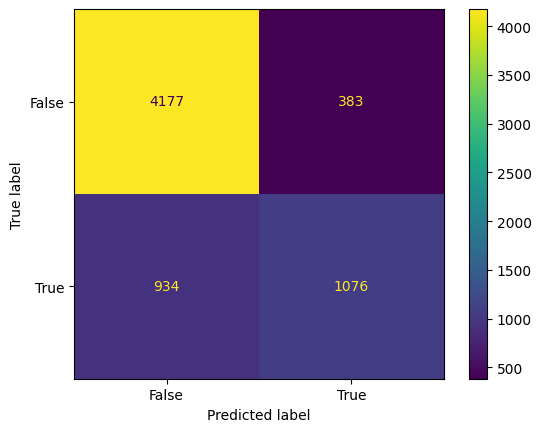

Biased Female Subgroup Confusion Matrix


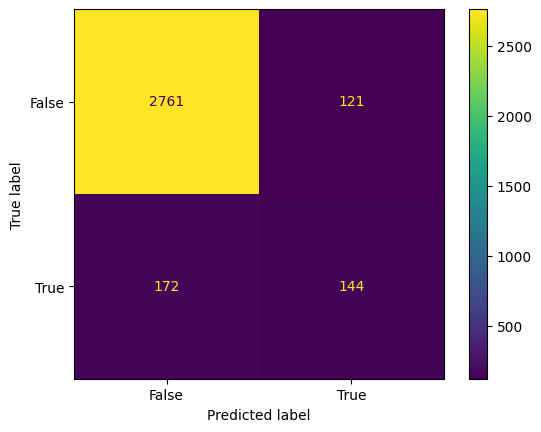

Biased Adversary correctly predicting Male: 87 %
Biased Adversary incorrectly predicting Male: 12 %

Biased Classifier False Positive income prediction on Male subgroup: 0.0840 
Biased Classifier False Negative income prediction on Male subgroup: 0.4647 

Biased Adversary correctly predicting Female: 73 %
Biased Adversary incorrectly predicting Female: 26 %

Biased Classifier False Positive income prediction on Female subgroup: 0.0420 
Biased Classifier False Negative income prediction on Female subgroup: 0.5443 

Accuracy of the Unbiased model based on the test set of 9768 x_test is: 84 %

Unbiased Male Subgroup Confusion Matrix


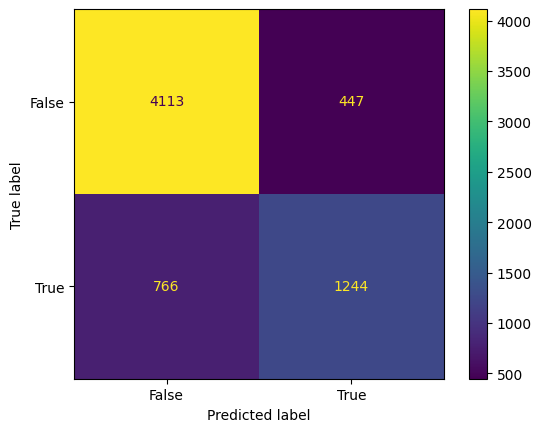

Unbiased Female Subgroup Confusion Matrix


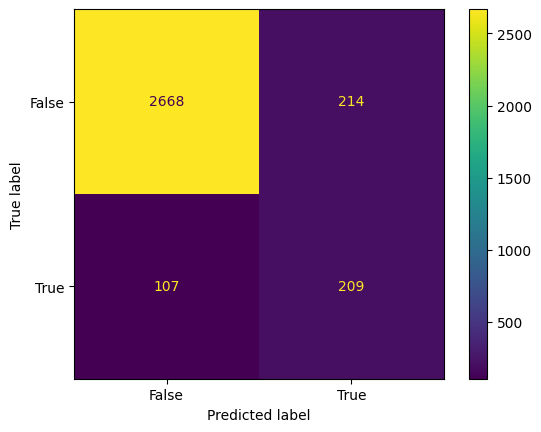

Unbiased Adversary correctly predicting Male: 99 %
Unbiased Adversary incorrectly predicting Male:  0 %

Unbiased Classifier False Positive income prediction on Male subgroup: 0.0980 
Unbiased Classifier False Negative income prediction on Male subgroup: 0.3811 

Unbiased Adversary correctly predicting Female:  0 %
Unbiased Adversary incorrectly predicting Female: 99 %

Unbiased Classifier False Positive income prediction on Female subgroup: 0.0743 
Unbiased Classifier False Negative income prediction on Female subgroup: 0.3386 



In [ ]:
if __name__ == "__main__":
  num_epochs = 5 # training and validation loss start to diverge around 55-60
  # pretrain(num_epochs)
  train(num_epochs)
  debias(num_epochs)
  print('Finished Training\n') 
  test("NetModel.pth", "AdvBiasedModel.pth", "Biased")
  test("NetModelFair.pth", "AdvModel.pth", "Unbiased") 
